In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from math import sqrt

import xgboost as xgb
from fbprophet import Prophet

import functions as f # bespoke project functions

In [2]:
train_x = pd.read_csv("train_x.csv", parse_dates = ['timestamp'],
                      date_parser = lambda x: pd.to_datetime(x, format = '%Y-%m-%d %H:%M:%S'))
train_y = pd.read_csv("train_y.csv")

test_x = pd.read_csv("test_x.csv", parse_dates = ['timestamp'],
                     date_parser = lambda x: pd.to_datetime(x, format = '%Y-%m-%d %H:%M:%S'))
test_y = pd.read_csv("test_y.csv")

In [3]:
train_x, eval_x = f.train_test_split(train_x, 15)
train_y, eval_y = f.train_test_split(train_y, 15)

In [4]:
train_x.head()

,timestamp,temperature,temperature_feel,humidity,wind_speed,weather_code,holiday_flag,weekend_flag,season
0,2015-01-04 00:00:00,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


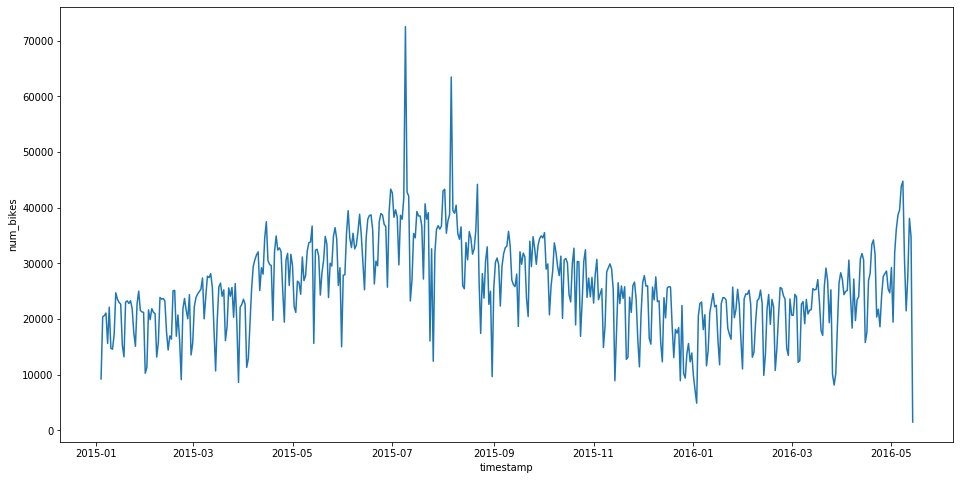

In [5]:
# group sales into daily view, so we get a neater view of trend
grouped_bikes = train_x[['timestamp']].copy() 
grouped_bikes['num_bikes'] = train_y['num_bikes'].copy()
grouped_bikes = pd.DataFrame(grouped_bikes.groupby(grouped_bikes['timestamp'].dt.date)['num_bikes'].sum())

# lineplot shows a bit of variance, the peaks will likely be weekends
plt.figure(figsize = (16,8))
sns.lineplot(x = grouped_bikes.index,
             y = grouped_bikes['num_bikes']);

### Prophet

In [6]:
# Prophet is facebook's forecasting algorithm, and is used internally a lot. It is extremely powerful, and simple to implement

In [7]:
mod = Prophet(
              yearly_seasonality=True,
              seasonality_prior_scale=2,
              n_changepoints=10,
              weekly_seasonality = True,
              daily_seasonality = True,
              seasonality_mode='multiplicative'
        )

In [8]:
# prophet has a slightly different way of adding regressors - they can't just be supplied unexpectedly
additional_regressors = ['temperature', 'temperature_feel', 'humidity','wind_speed', 'weather_code', 'holiday_flag', 
                         'weekend_flag', 'season']

for regressor in additional_regressors:
    mod.add_regressor(regressor)

In [9]:
train = train_x.merge(train_y, left_index = True, right_index = True)
train = f.column_renamer(train) # prophet expects your time-column and your outcome-column to be named specifically

In [10]:
mod.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [11]:
eval_x = f.column_renamer(eval_x)

In [12]:
preds = mod.predict(eval_x)['yhat']

In [13]:
prophet_result = sqrt(mean_squared_error(eval_y, preds)) # evaluate performance
print(f"prophet RMSE is {round(prophet_result, 2)}")

prophet RMSE is 707.43


In [ ]:
# prophet isn't predicting very well. It's probably because it doesn't have a good view of the yearly seasonality - as
# there's only a year and a half of data (the hour-level data is making the df much bigger).

### XGBoost

In [34]:
# xgboost (eXtreme Gradient Boosting) is an ensembling model, with gradient boosting. It is both fast and reliable.
# gradient boosting means that new models are created that predict the residuals of prior models.

In [3]:
# re-define these, as we've tampered with them for prophet
train_x, eval_x = f.train_test_split(train_x, 15)
train_y, eval_y = f.train_test_split(train_y, 15)

In [4]:
xgboost_train_x = f.create_date_components(train_x.copy()) # has to be .copy() so we don't add columns inplace
xgboost_eval_x = f.create_date_components(eval_x.copy())

In [27]:
# instantiate model
reg = xgb.XGBRegressor(n_estimators=100, # no drastic improvement beyond 100 estimators 
                       max_depth = 10, 
                       learning_rate = 0.1,
                       eval_metric = 'rmse',
                       gamma = 3,
                       objective = 'reg:squarederror', 
                       random_state = 42)

reg.fit(xgboost_train_x, train_y ,
        early_stopping_rounds = 20, eval_set = [(xgboost_eval_x, eval_y)],
        eval_metric = 'rmse'
       ) 

[0]	validation_0-rmse:1709.77
Will train until validation_0-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:1554.99
[2]	validation_0-rmse:1414.84
[3]	validation_0-rmse:1291.59
[4]	validation_0-rmse:1181.15
[5]	validation_0-rmse:1080.5
[6]	validation_0-rmse:991.281
[7]	validation_0-rmse:910.333
[8]	validation_0-rmse:837.578
[9]	validation_0-rmse:774.733
[10]	validation_0-rmse:716.45
[11]	validation_0-rmse:665.09
[12]	validation_0-rmse:620.919
[13]	validation_0-rmse:578.867
[14]	validation_0-rmse:542.791
[15]	validation_0-rmse:509.778
[16]	validation_0-rmse:482.098
[17]	validation_0-rmse:456.311
[18]	validation_0-rmse:434.063
[19]	validation_0-rmse:415.215
[20]	validation_0-rmse:398.325
[21]	validation_0-rmse:382.906
[22]	validation_0-rmse:370.748
[23]	validation_0-rmse:358.024
[24]	validation_0-rmse:347.618
[25]	validation_0-rmse:336.363
[26]	validation_0-rmse:327.573
[27]	validation_0-rmse:320.892
[28]	validation_0-rmse:315.697
[29]	validation_0-rmse:311.179
[30]	validation_0-

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=3, importance_type='gain', learning_rate=0.1,
             max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
             n_estimators=100, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=1, verbosity=1)

In [28]:
# max_depth = 10
preds = reg.predict(xgboost_eval_x) # make predictions
xgboost_result = sqrt(mean_squared_error(eval_y, preds)) # evaluate performance

print(f"xgboost RMSE is {round(xgboost_result, 2)}")

xgboost RMSE is 282.3


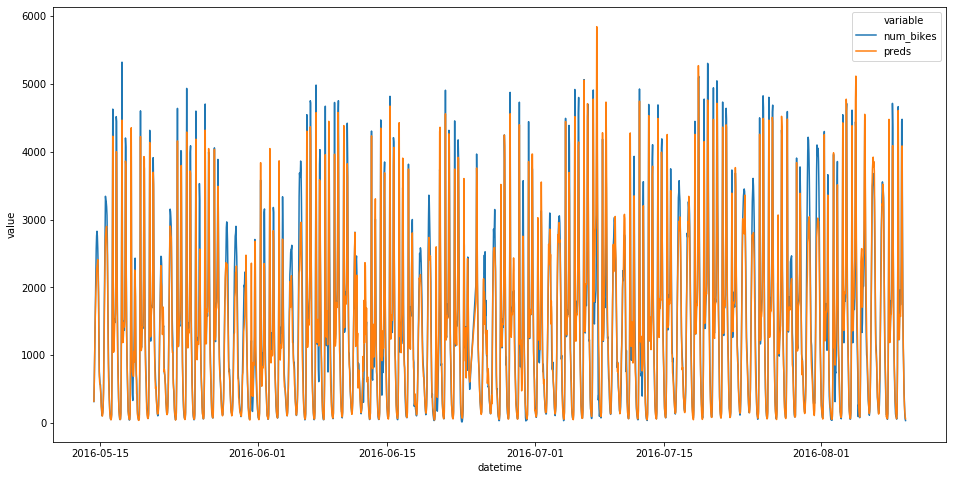

In [29]:
# create dataframe to plot
xgboost_plot = eval_y.copy()
xgboost_plot['datetime'] = eval_x['timestamp'].copy()
xgboost_plot['preds'] = preds
xgboost_plot = xgboost_plot.melt(value_vars = ['num_bikes', 'preds'], id_vars = 'datetime')

# show visualisation
plt.figure(figsize = (16,8))
sns.lineplot(x = xgboost_plot['datetime'], y = xgboost_plot['value'], hue = xgboost_plot['variable'])

In [47]:
# this is looking a lot better than prophet's model, and the RMSE is accordingly much lower.

In [30]:
### TEST DATASET
xgboost_test_x = f.create_date_components(test_x.copy())
preds = reg.predict(xgboost_test_x) # make predictions
xgboost_result = sqrt(mean_squared_error(test_y, preds)) # evaluate performance
print(f"xgboost RMSE on test is {round(xgboost_result, 2)}")

xgboost RMSE on test is 280.51


In [ ]:
# RMSE on test dataset is in line with eval datest, so we aren't overfitting